In [ ]:
!pip install pgmpy

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
sns.set()

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import accuracy_score
import networkx as nx

from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling
from pgmpy.inference import VariableElimination
from pgmpy.base import DAG

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Utils

In [ ]:
import math
from typing import List
from itertools import chain

# Plot Graph 
# Start and end are lists defining start and end points
# Edge x and y are lists used to construct the graph
# arrowAngle and arrowLength define properties of the arrowhead
# arrowPos is None, 'middle' or 'end' based on where on the edge you want the arrow to appear
# arrowLength is the length of the arrowhead
# arrowAngle is the angle in degrees that the arrowhead makes with the edge
# dotSize is the plotly scatter dot size you are using (used to even out line spacing when you have a mix of edge lengths)
def addEdge(start, end, edge_x, edge_y, lengthFrac=1, arrowPos = None, arrowLength=0.025, arrowAngle = 30, dotSize=20):

    # Get start and end cartesian coordinates
    x0, y0 = start
    x1, y1 = end

    # Incorporate the fraction of this segment covered by a dot into total reduction
    length = math.sqrt( (x1-x0)**2 + (y1-y0)**2 )
    dotSizeConversion = .0565/20 # length units per dot size
    convertedDotDiameter = dotSize * dotSizeConversion
    lengthFracReduction = convertedDotDiameter / length
    lengthFrac = lengthFrac - lengthFracReduction

    # If the line segment should not cover the entire distance, get actual start and end coords
    skipX = (x1-x0)*(1-lengthFrac)
    skipY = (y1-y0)*(1-lengthFrac)
    x0 = x0 + skipX/2
    x1 = x1 - skipX/2
    y0 = y0 + skipY/2
    y1 = y1 - skipY/2

    # Append line corresponding to the edge
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None) # Prevents a line being drawn from end of this edge to start of next edge
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

    # Draw arrow
    if not arrowPos == None:

        # Find the point of the arrow; assume is at end unless told middle
        pointx = x1
        pointy = y1

        eta = math.degrees(math.atan((x1-x0)/(y1-y0))) if y1!=y0 else 90.0

        if arrowPos == 'middle' or arrowPos == 'mid':
            pointx = x0 + (x1-x0)/2
            pointy = y0 + (y1-y0)/2

        # Find the directions the arrows are pointing
        signx = (x1-x0)/abs(x1-x0) if x1!=x0 else +1    #verify this once
        signy = (y1-y0)/abs(y1-y0) if y1!=y0 else +1    #verified

        # Append first arrowhead
        dx = arrowLength * math.sin(math.radians(eta + arrowAngle))
        dy = arrowLength * math.cos(math.radians(eta + arrowAngle))
        edge_x.append(pointx)
        edge_x.append(pointx - signx**2 * signy * dx)
        edge_x.append(None)
        edge_y.append(pointy)
        edge_y.append(pointy - signx**2 * signy * dy)
        edge_y.append(None)

        # And second arrowhead
        dx = arrowLength * math.sin(math.radians(eta - arrowAngle))
        dy = arrowLength * math.cos(math.radians(eta - arrowAngle))
        edge_x.append(pointx)
        edge_x.append(pointx - signx**2 * signy * dx)
        edge_x.append(None)
        edge_y.append(pointy)
        edge_y.append(pointy - signx**2 * signy * dy)
        edge_y.append(None)


    return edge_x, edge_y

In [ ]:
# Adding arrows to Graph
def add_arrows(source_x: List[float], target_x: List[float], source_y: List[float], target_y: List[float],
               arrowLength=0.025, arrowAngle=30):
    pointx = list(map(lambda x: x[0] + (x[1] - x[0]) / 2, zip(source_x, target_x)))
    pointy = list(map(lambda x: x[0] + (x[1] - x[0]) / 2, zip(source_y, target_y)))
    etas = list(map(lambda x: math.degrees(math.atan((x[1] - x[0]) / (x[3] - x[2]))),
                    zip(source_x, target_x, source_y, target_y)))

    signx = list(map(lambda x: (x[1] - x[0]) / abs(x[1] - x[0]), zip(source_x, target_x)))
    signy = list(map(lambda x: (x[1] - x[0]) / abs(x[1] - x[0]), zip(source_y, target_y)))

    dx = list(map(lambda x: arrowLength * math.sin(math.radians(x + arrowAngle)), etas))
    dy = list(map(lambda x: arrowLength * math.cos(math.radians(x + arrowAngle)), etas))
    none_spacer = [None for _ in range(len(pointx))]
    arrow_line_x = list(map(lambda x: x[0] - x[1] ** 2 * x[2] * x[3], zip(pointx, signx, signy, dx)))
    arrow_line_y = list(map(lambda x: x[0] - x[1] ** 2 * x[2] * x[3], zip(pointy, signx, signy, dy)))

    arrow_line_1x_coords = list(chain(*zip(pointx, arrow_line_x, none_spacer)))
    arrow_line_1y_coords = list(chain(*zip(pointy, arrow_line_y, none_spacer)))

    dx = list(map(lambda x: arrowLength * math.sin(math.radians(x - arrowAngle)), etas))
    dy = list(map(lambda x: arrowLength * math.cos(math.radians(x - arrowAngle)), etas))
    none_spacer = [None for _ in range(len(pointx))]
    arrow_line_x = list(map(lambda x: x[0] - x[1] ** 2 * x[2] * x[3], zip(pointx, signx, signy, dx)))
    arrow_line_y = list(map(lambda x: x[0] - x[1] ** 2 * x[2] * x[3], zip(pointy, signx, signy, dy)))

    arrow_line_2x_coords = list(chain(*zip(pointx, arrow_line_x, none_spacer)))
    arrow_line_2y_coords = list(chain(*zip(pointy, arrow_line_y, none_spacer)))

    x_arrows = arrow_line_1x_coords + arrow_line_2x_coords
    y_arrows = arrow_line_1y_coords + arrow_line_2y_coords

    return x_arrows, y_arrows

In [ ]:
def graph_node(graph):
    node_x = []
    node_y = []
    node_name = []

    for node in graph.nodes():
      x, y = graph.nodes[node]['pos']
      node_x.append(x)
      node_y.append(y)
      node_name.append(node)

    return node_x, node_y, node_name

In [ ]:
def graph_edge(graph, node_size=20):
    edge_x = []
    edge_y = []

    for edge in graph.edges():
        start = graph.nodes[edge[0]]['pos']
        end = graph.nodes[edge[1]]['pos']
        edge_x, edge_y = addEdge(start, end, edge_x, edge_y, .8, 'end', .04, 30, node_size)

    return edge_x, edge_y

In [ ]:
def plot_graph(model, node_color='#FF22FF', node_size=20, line_width=2, line_color='#000000'):
  # Making graph
  graph = nx.DiGraph()
  graph.add_edges_from(model.edges())
  pos = nx.layout.circular_layout(graph)

  for node in graph.nodes:
    graph.nodes[node]['pos'] = list(pos[node])

  # Making list of nodes for plotly
  node_x, node_y, node_name = graph_node(graph)

  # Making a list of edges for plotly, including line segments that result in arrowheads
  edge_x, edge_y = graph_edge(graph, node_size)

  edge_trace = go.Scatter(x=edge_x,
                          y=edge_y,
                          line=dict(width=line_width, color=line_color),
                          hoverinfo='none',
                          mode='lines')

  node_trace = go.Scatter(x=node_x,
                          y=node_y,
                          mode='markers+text',
                          hoverinfo='text',
                          text=node_name,
                          textposition="top center",
                          marker=dict(showscale=False,
                                      color=node_color,
                                      size=node_size)
                          )

  fig = go.Figure(data=[edge_trace, node_trace],
                  layout=go.Layout(
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                  )
                
  # Note: if you don't use fixed ratio axes, the arrows won't be symmetrical
  fig.update_layout(yaxis=dict(scaleanchor="x", scaleratio=1), plot_bgcolor='rgb(255,255,255)')

  fig.show()

In [ ]:
def accuracy_params_restoration(bn: BayesianModel, data: pd.DataFrame):
    bn.fit(data)
    result = pd.DataFrame(columns=['Parameter', 'accuracy'])
    bn_infer = VariableElimination(bn)
    for j, param in enumerate(data.columns):
        accuracy = 0
        test_param = data[param].copy()
        test_data = data.drop(columns=param)
        evidence = test_data.to_dict('records')
        predicted_param = []
        for element in evidence:
            prediction = bn_infer.map_query(variables=[param], evidence=element)
            predicted_param.append(prediction[param])
        accuracy = accuracy_score(test_param.values, predicted_param)
        result.loc[j,'Parameter'] = param
        result.loc[j, 'accuracy'] = accuracy
    return result

## Dataset

In [ ]:
original_data = pd.read_csv("/content/drive/My Drive/multivariate/life_expectancy.csv")

In [ ]:
original_data.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [ ]:
# rename columns
original_data = original_data.rename({
                  'Life expectancy ': 'Life expectancy',
                  'infant deaths': 'Infant deaths', 
                  'percentage expenditure': 'Percentage expenditure',
                  'Measles ': 'Measles',
                  ' BMI ': 'BMI',
                  'under-five deaths ': 'Under-five deaths',
                  'Diphtheria ': 'Diphtheria',
                  ' HIV/AIDS': 'HIV/AIDS',
                  ' thinness  1-19 years': 'Thinness 1-19 years',
                  ' thinness 5-9 years': 'Thinness 5-9 years',
}, axis='columns')

original_data.columns

Index(['Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality',
       'Infant deaths', 'Alcohol', 'Percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'Under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'Thinness 1-19 years',
       'Thinness 5-9 years', 'Income composition of resources', 'Schooling'],
      dtype='object')

In [ ]:
original_data.describe()

,Year,Life expectancy,Adult Mortality,Infant deaths,Alcohol,Percentage expenditure,Hepatitis B,Measles,BMI,Under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,Thinness 1-19 years,Thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


In [ ]:
# Filling NaNs
def imputer(data, feature, method):
    if method == "mode":
        data[feature] = data[feature].fillna(data[feature].mode()[0])
    elif method == "median":
        data[feature] = data[feature].fillna(data[feature].median())
    else:
        data[feature] = data[feature].fillna(data[feature].mean())

## Step 1

Choose variables for sampling from your dataset (overall – about 10 variables: 3-4 –
target variables, the rest - predictors).

In [ ]:
vars_subsample = [ 
                  'Country', # help to vis
                  'Status', # help to sample

                  'Life expectancy', # target 
                  'BMI', # target
                  'GDP', # target
                  
                  'Adult Mortality', # predictor
                  'Infant deaths', # predictor
                  'Alcohol', # predictor
                  # 'Percentage expenditure',
                  # 'Hepatitis B',
                  # 'Measles',
                  # 'Under-five deaths', 
                  'Polio', # predictor
                  'Total expenditure', # predictor
                  'Diphtheria',  # predictor
                  # 'HIV/AIDS',
                  # 'Population',
                  # 'Thinness 1-19 years',
                  # 'Thinness 5-9 years',
                  # 'Income composition of resources',
                  'Schooling', # predictor
                  # 'Year',
]

In [ ]:
data = original_data[vars_subsample].copy()
data['Status'] = data['Status'].replace({'Developing': 0, 'Developed': 1})

features_missing = data.columns[data.isna().any()]

for feature in features_missing:
  imputer(data, feature, method='mean')

## Step 2

Using univariate parametric distributions that were fitted in Lab#2 make sampling of
chosen target variables. Use for this 2 different sampling methods.

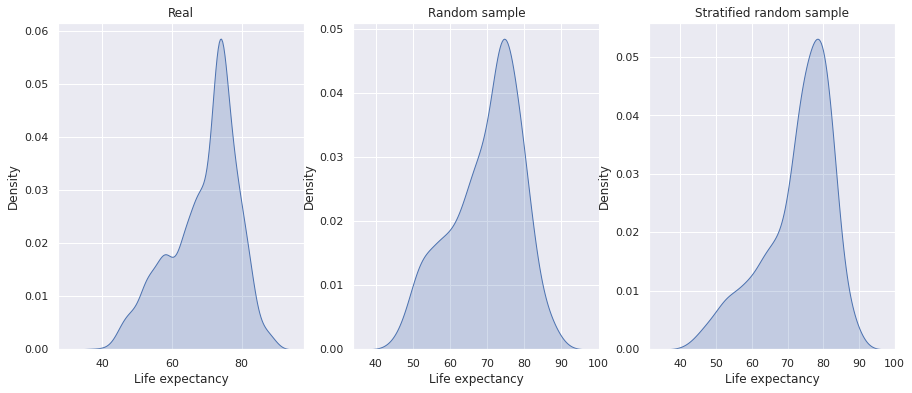

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

sns.kdeplot(ax=axes[0], data=data, x='Life expectancy', shade=True)

# Random sample
sample_data = data.sample(frac=.15)
sns.kdeplot(ax=axes[1], data=sample_data, x='Life expectancy', shade=True)

# Stratified random sample
sample_data_0 = data[data['Status'] == 0].sample(n=300, axis=0)
sample_data_1 = data[data['Status'] == 1].sample(n=300, axis=0)
sample_data = pd.concat([sample_data_0, sample_data_1])
sns.kdeplot(ax=axes[2], data=sample_data, x='Life expectancy', shade=True)

axes[0].set_title('Real')
axes[1].set_title('Random sample')
axes[2].set_title('Stratified random sample')
plt.show()

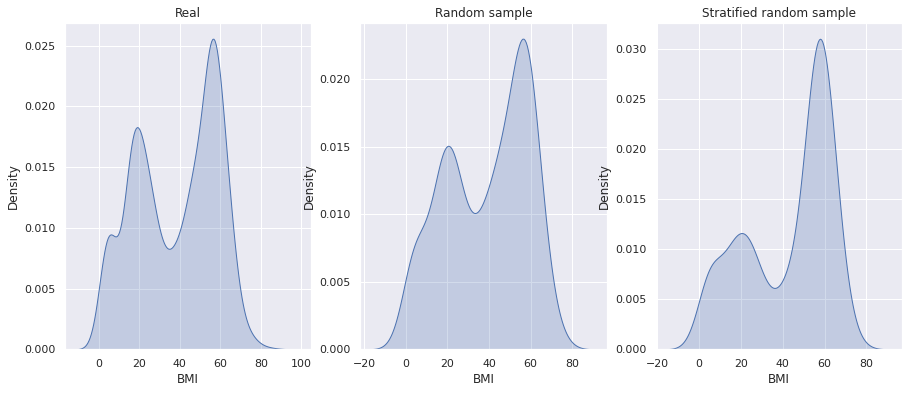

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

sns.kdeplot(ax=axes[0], data=data, x='BMI', shade=True)

# Random sample
sample_data = data.sample(frac=.15)
sns.kdeplot(ax=axes[1], data=sample_data, x='BMI', shade=True)

# Stratified random sample
sample_data_0 = data[data['Status'] == 0].sample(n=300, axis=0)
sample_data_1 = data[data['Status'] == 1].sample(n=300, axis=0)
sample_data = pd.concat([sample_data_0, sample_data_1])
sns.kdeplot(ax=axes[2], data=sample_data, x='BMI', shade=True)

axes[0].set_title('Real')
axes[1].set_title('Random sample')
axes[2].set_title('Stratified random sample')
plt.show()

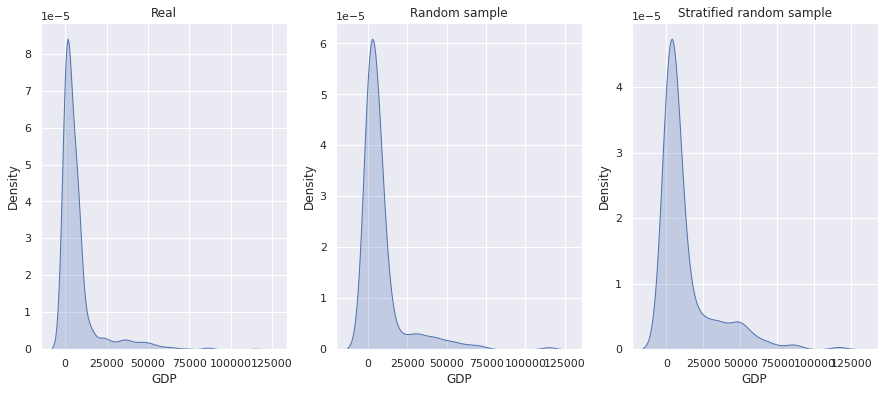

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

sns.kdeplot(ax=axes[0], data=data, x='GDP', shade=True)

# Random sample
sample_data = data.sample(frac=.15)
sns.kdeplot(ax=axes[1], data=sample_data, x='GDP', shade=True)

# Stratified random sample
sample_data_0 = data[data['Status'] == 0].sample(n=300, axis=0)
sample_data_1 = data[data['Status'] == 1].sample(n=300, axis=0)
sample_data = pd.concat([sample_data_0, sample_data_1])
sns.kdeplot(ax=axes[2], data=sample_data, x='GDP', shade=True)

axes[0].set_title('Real')
axes[1].set_title('Random sample')
axes[2].set_title('Stratified random sample')
plt.show()

## Step 3

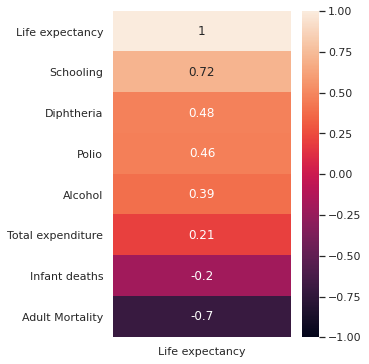

In [ ]:
plt.figure(figsize=(4, 6))
sample_cols = [vars_subsample[2]] + vars_subsample[5:]
sns.heatmap(data[sample_cols].corr()[['Life expectancy']].sort_values(by='Life expectancy', ascending=False), vmin=-1, vmax=1, annot=True)
plt.show()

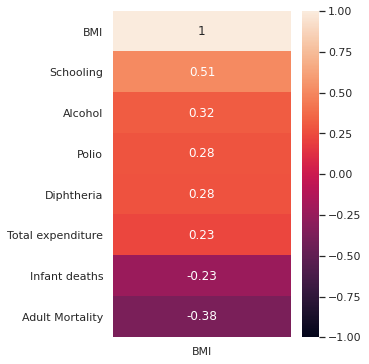

In [ ]:
plt.figure(figsize=(4, 6))
sample_cols = [vars_subsample[3]] + vars_subsample[5:]
sns.heatmap(data[sample_cols].corr()[['BMI']].sort_values(by='BMI', ascending=False), vmin=-1, vmax=1, annot=True)
plt.show()

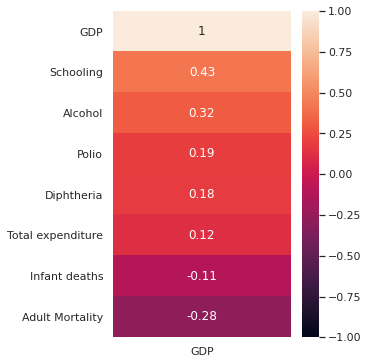

In [ ]:
plt.figure(figsize=(4, 6))
sample_cols = [vars_subsample[4]] + vars_subsample[5:]
sns.heatmap(data[sample_cols].corr()[['GDP']].sort_values(by='GDP', ascending=False), vmin=-1, vmax=1, annot=True)
plt.show()

## Step 4

Build a Bayesian network for chosen set of variables. Choose its structure on the basis
of multivariate analysis and train distributions in nodes using chosen algorithm.

### K2Score

In [ ]:
transformed_data = data.iloc[:, 2:].copy()
est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
data_discrete = est.fit_transform(data[vars_subsample[2:]].values)
transformed_data[vars_subsample[2:]] = data_discrete
transformed_data.shape

(2938, 10)

In [ ]:
data['Life expectancy'].max()

89.0

In [ ]:
transformed_data.head()

,Life expectancy,BMI,GDP,Adult Mortality,Infant deaths,Alcohol,Polio,Total expenditure,Diphtheria,Schooling
0,2.0,1.0,0.0,2.0,0.0,0.0,0.0,2.0,2.0,2.0
1,1.0,1.0,0.0,2.0,0.0,0.0,1.0,2.0,2.0,2.0
2,1.0,1.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0
3,1.0,1.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,1.0
4,1.0,1.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,1.0


In [ ]:
hc = HillClimbSearch(transformed_data,
                     scoring_method=K2Score(transformed_data))

K2Score_model = hc.estimate()

plot_graph(K2Score_model)

  0%|          | 23/1000000 [00:02<32:07:07,  8.65it/s]


In [ ]:
blacklist = [(x, y) for x in transformed_data.columns.to_list() for y in vars_subsample[5:] if x != y]

In [ ]:
K2Score_model_bl = hc.estimate(black_list=blacklist)
plot_graph(K2Score_model_bl)

  0%|          | 7/1000000 [00:00<31:33:49,  8.80it/s]


In [ ]:
not_in_blacklist = ['Adult Mortality',
                    'BMI',
                    'Life expectancy',
                    'GDP',
                    'Schooling',
                    'Alcohol',
                    'Infant deaths',
]

accuracy_k2 = accuracy_params_restoration(BayesianModel(K2Score_model_bl.edges()),
                                          transformed_data[not_in_blacklist].sample(frac=0.3))

Выходные данные были обрезаны до нескольких последних строк (5000).
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it 

In [ ]:
accuracy_k2

,Parameter,accuracy
0,Adult Mortality,0.599319
1,BMI,0.597049
2,Life expectancy,0.772985
3,GDP,0.862656
4,Schooling,0.53916
5,Alcohol,0.451759
6,Infant deaths,0.963678


## Step 5
Build a Bayesian network for the same set of variables but using 2 chosen algorithms
for structural learning.

### BicScore

In [ ]:
hc_BicScore = HillClimbSearch(transformed_data,
                              scoring_method=BicScore(transformed_data))

BicScore_model = hc_BicScore.estimate()

plot_graph(BicScore_model)

  0%|          | 23/1000000 [00:02<31:37:46,  8.78it/s]


In [ ]:
BicScore_model_bl = hc_BicScore.estimate(black_list=blacklist)

plot_graph(BicScore_model_bl)

  0%|          | 7/1000000 [00:00<29:21:44,  9.46it/s]


In [ ]:
not_in_blacklist = ['Adult Mortality',
                    'BMI',
                    'Life expectancy',
                    'GDP',
                    'Schooling',
                    'Alcohol',
                    'Infant deaths',
]

accuracy_k2 = accuracy_params_restoration(BayesianModel(BicScore_model_bl.edges()),
                                          transformed_data[not_in_blacklist].sample(frac=0.3))

Выходные данные были обрезаны до нескольких последних строк (5000).
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it 

In [ ]:
accuracy_k2

,Parameter,accuracy
0,Adult Mortality,0.624291
1,BMI,0.585698
2,Life expectancy,0.780931
3,GDP,0.849035
4,Schooling,0.572077
5,Alcohol,0.45403
6,Infant deaths,0.963678


### BDeuScore

In [ ]:
hc_BDeuScore = HillClimbSearch(transformed_data,
                               scoring_method=BDeuScore(transformed_data))

BDeuScore_model = hc_BDeuScore.estimate()

plot_graph(BDeuScore_model)

  0%|          | 23/1000000 [00:02<29:02:14,  9.57it/s]


In [ ]:
BDeuScore_model_bl = hc_BDeuScore.estimate(black_list=blacklist)

plot_graph(BDeuScore_model_bl)

  0%|          | 7/1000000 [00:00<30:41:21,  9.05it/s]


In [ ]:
not_in_blacklist = ['Adult Mortality',
                    'BMI',
                    'Life expectancy',
                    'GDP',
                    'Schooling',
                    'Alcohol',
                    'Infant deaths',
]

accuracy_k2 = accuracy_params_restoration(BayesianModel(BDeuScore_model_bl.edges()),
                                          transformed_data[not_in_blacklist].sample(frac=0.3))

Выходные данные были обрезаны до нескольких последних строк (5000).
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it 

In [ ]:
accuracy_k2

,Parameter,accuracy
0,Adult Mortality,0.586833
1,BMI,0.602724
2,Life expectancy,0.770715
3,GDP,0.821793
4,Schooling,0.609535
5,Alcohol,0.46084
6,Infant deaths,0.969353


## Step 6

Analyze a quality of sampled target variables from the point of view of problem
statement (e.g. prediction, gap filling, synthetic generation).

In [ ]:
def sampling (bn: DAG, data: pd.DataFrame, n: int = 100):
    bn_new = BayesianModel(bn.edges())
    bn_new.fit(data)
    sampler = BayesianModelSampling(bn_new)
    sample = sampler.forward_sample(size=n, return_type='dataframe')
    return sample

In [ ]:
def draw_comparative_hist (parametr: str, original_data: pd.DataFrame, data_sampled: pd.DataFrame, axes=None):
    final_df = pd.DataFrame()
    
    df1 = pd.DataFrame()
    df1[parametr] = original_data[parametr]
    df1['Data'] = 'Original data'
    df1['Probability'] = df1[parametr].apply(lambda x: (df1.groupby(parametr)[parametr].count()[x])/original_data.shape[0])
    
    df2 = pd.DataFrame()
    df2[parametr] = data_sampled[parametr]
    df2['Data'] = 'Synthetic data'
    df2['Probability'] = df2[parametr].apply(lambda x: (df2.groupby(parametr)[parametr].count()[x])/data_sampled.shape[0])
    final_df = pd.concat([df1, df2])
    
    sns.barplot(ax=axes, x=parametr, y="Probability", hue="Data", data=final_df)

In [ ]:
sample_K2 = sampling(K2Score_model_bl, transformed_data, transformed_data.shape[0])
sample_Bic = sampling(BicScore_model_bl, transformed_data, transformed_data.shape[0])
sample_BDeu = sampling(BDeuScore_model_bl, transformed_data, transformed_data.shape[0])

Generating for node: BMI: 100%|██████████| 7/7 [00:00<00:00, 44.79it/s]


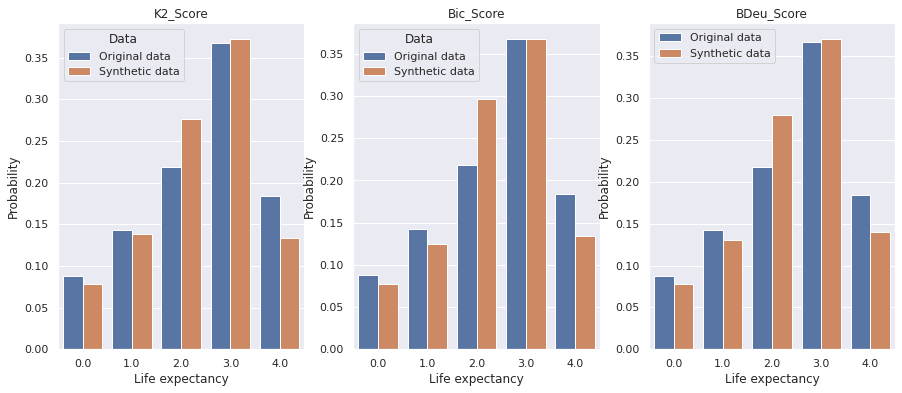

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

draw_comparative_hist('Life expectancy', transformed_data, sample_K2, axes=axes[0])
draw_comparative_hist('Life expectancy', transformed_data, sample_Bic, axes=axes[1])
draw_comparative_hist('Life expectancy', transformed_data, sample_BDeu, axes=axes[2])

axes[0].set_title('K2_Score')
axes[1].set_title('Bic_Score')
axes[2].set_title('BDeu_Score')
plt.legend()
plt.show()

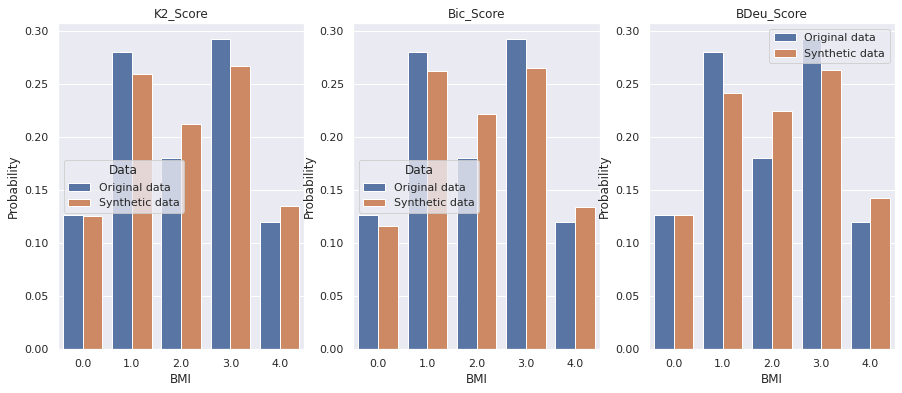

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

draw_comparative_hist('BMI', transformed_data, sample_K2, axes=axes[0])
draw_comparative_hist('BMI', transformed_data, sample_Bic, axes=axes[1])
draw_comparative_hist('BMI', transformed_data, sample_BDeu, axes=axes[2])

axes[0].set_title('K2_Score')
axes[1].set_title('Bic_Score')
axes[2].set_title('BDeu_Score')
plt.legend()
plt.show()

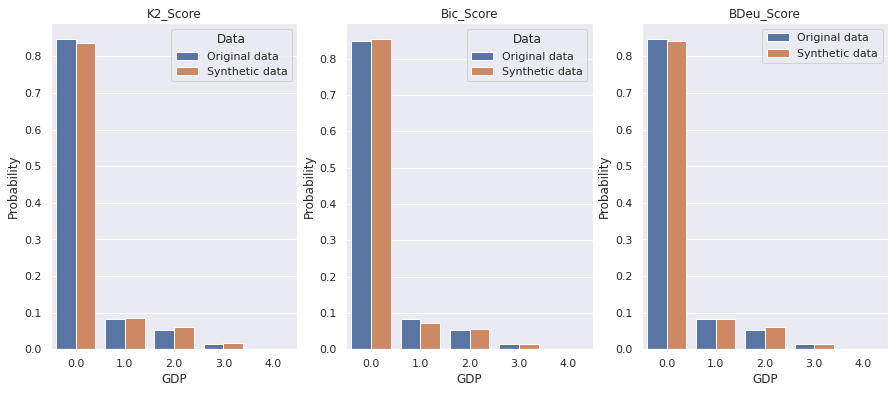

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

draw_comparative_hist('GDP', transformed_data, sample_K2, axes=axes[0])
draw_comparative_hist('GDP', transformed_data, sample_Bic, axes=axes[1])
draw_comparative_hist('GDP', transformed_data, sample_BDeu, axes=axes[2])

axes[0].set_title('K2_Score')
axes[1].set_title('Bic_Score')
axes[2].set_title('BDeu_Score')
plt.legend()
plt.show()

In [ ]:
for in_blacklist in list(set(transformed_data.columns) - set(sample_K2.columns)):
  sample_K2[in_blacklist] = transformed_data[in_blacklist].copy()
  sample_Bic[in_blacklist] = transformed_data[in_blacklist].copy()
  sample_BDeu[in_blacklist] = transformed_data[in_blacklist].copy()

In [ ]:
sample_K2[sample_K2.columns] = est.inverse_transform(sample_K2[sample_K2.columns].values)
sample_Bic[sample_K2.columns] = est.inverse_transform(sample_Bic[sample_K2.columns].values)
sample_BDeu[sample_K2.columns] = est.inverse_transform(sample_BDeu[sample_K2.columns].values)

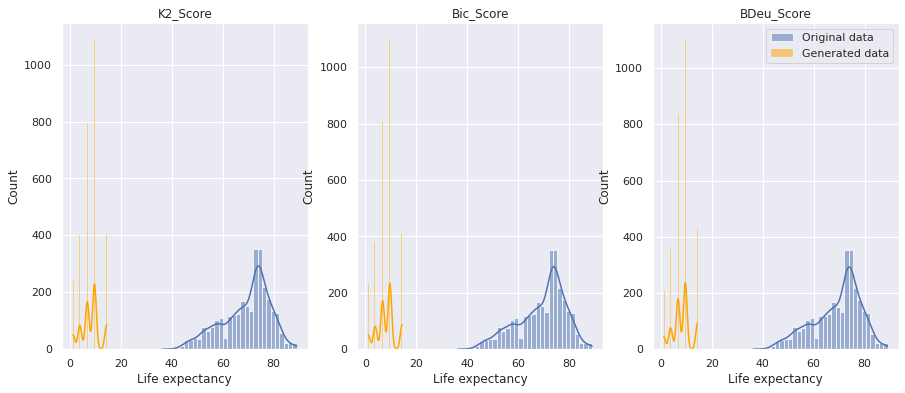

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

sns.histplot(data['Life expectancy'], label='Original data', kde=True, ax=axes[0])
sns.histplot(sample_K2['Life expectancy'], label='Generated data', kde=True, color='orange', ax=axes[0])

sns.histplot(data['Life expectancy'], label='Original data', kde=True, ax=axes[1])
sns.histplot(sample_Bic['Life expectancy'], label='Generated data', kde=True, color='orange', ax=axes[1])

sns.histplot(data['Life expectancy'], label='Original data', kde=True, ax=axes[2])
sns.histplot(sample_BDeu['Life expectancy'], label='Generated data', kde=True, color='orange', ax=axes[2])

axes[0].set_title('K2_Score')
axes[1].set_title('Bic_Score')
axes[2].set_title('BDeu_Score')
plt.legend()
plt.show()

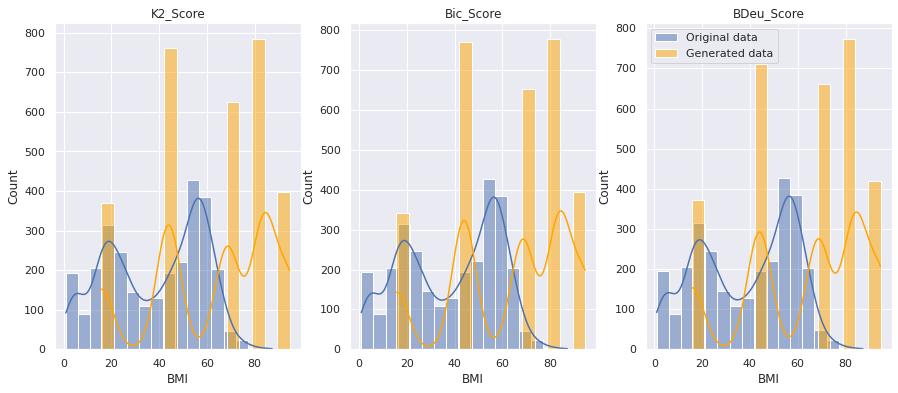

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

sns.histplot(data['BMI'], label='Original data', kde=True, ax=axes[0])
sns.histplot(sample_K2['BMI'], label='Generated data', kde=True, color='orange', ax=axes[0])

sns.histplot(data['BMI'], label='Original data', kde=True, ax=axes[1])
sns.histplot(sample_Bic['BMI'], label='Generated data', kde=True, color='orange', ax=axes[1])

sns.histplot(data['BMI'], label='Original data', kde=True, ax=axes[2])
sns.histplot(sample_BDeu['BMI'], label='Generated data', kde=True, color='orange', ax=axes[2])

axes[0].set_title('K2_Score')
axes[1].set_title('Bic_Score')
axes[2].set_title('BDeu_Score')
plt.legend()
plt.show()

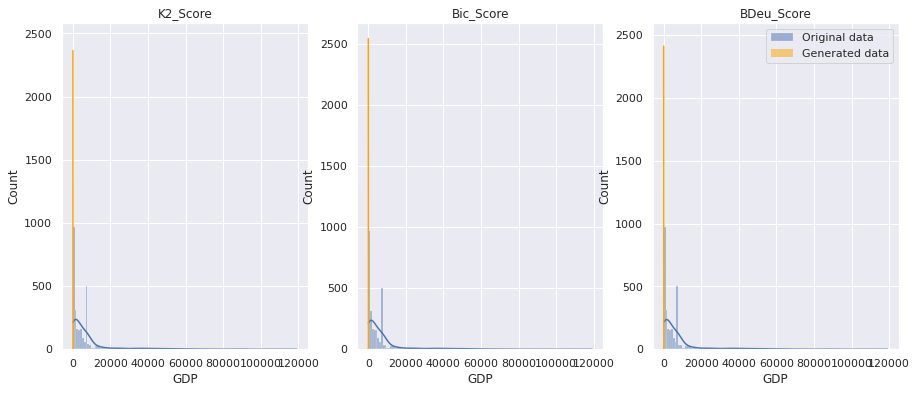

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

sns.histplot(data['GDP'], label='Original data', kde=True, ax=axes[0])
sns.histplot(sample_K2['GDP'], label='Generated data', kde=True, color='orange', ax=axes[0])

sns.histplot(data['GDP'], label='Original data', kde=True, ax=axes[1])
sns.histplot(sample_Bic['GDP'], label='Generated data', kde=True, color='orange', ax=axes[1])

sns.histplot(data['GDP'], label='Original data', kde=True, ax=axes[2])
sns.histplot(sample_BDeu['GDP'], label='Generated data', kde=True, color='orange', ax=axes[2])

axes[0].set_title('K2_Score')
axes[1].set_title('Bic_Score')
axes[2].set_title('BDeu_Score')
plt.legend()
plt.show()